In [1]:
import torch
import torch.nn as nn

from torch.optim import Adam, SGD
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

import random
from PIL import Image
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt


import pylab as pl
from IPython import display

## Segmentació d'objectes emprant Unet

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

**Feina a fer**

Un cop teniu els conjunts de dades creats heu de comprovar que les imatges que es corresponen amb les etiquetes tenen la informació correcta, feis una visualització.

In [3]:
import os
# Set the current working directory
path_train = os.path.join(os.getcwd(), "..","09_FCN", "data", "aixi_shape_256_texture", "train")
files = os.listdir(path_train)
img_files = [os.path.join(path_train, p) for p in files if p.endswith(".png")][:500]
label_files = [os.path.join(path_train, "gt", p) for p in files if p.endswith(".png")][:500]
print("total training images", len(img_files))

path_val = os.path.join(os.getcwd(), "..","09_FCN", "data", "aixi_shape_256_texture", "val")
files = os.listdir(path_val)
img_files_val = [os.path.join(path_train, p) for p in files if p.endswith(".png")][:200]
label_files_val = [os.path.join(path_train, "gt", p) for p in files if p.endswith(".png")][:200]
print("total test images", len(img_files_val))

total training images 500
total test images 200


In [4]:
train_batch_size = 64
test_batch_size = 100
mean, std = [1.9491e-05, 4.0427e-05, 3.6870e-05], [0.0003, 0.0004, 0.0004]

# Definim una seqüència (composició) de transformacions
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize(mean, std)
    ]
)


# Constructor del dataset.
class Formes(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        path = self.paths[index]
        label = self.labels[index]
        image = cv2.imread(path)  # , cv2.IMREAD_GRAYSCALE)  # Depén de vosaltres

        label_img = cv2.imread(label)
        label_img = cv2.add(label_img[:, :, 0], cv2.add(label_img[:, :, 1], label_img[:, :, 2]))

        if self.transform:
            image = self.transform(image)
            label_img = self.transform(label_img)

        return image, label_img


train_data = Formes(img_files, label_files, transform)
val_data = Formes(img_files_val, label_files_val, transform)

train_loader = torch.utils.data.DataLoader(train_data, train_batch_size)
val_loader = torch.utils.data.DataLoader(val_data, test_batch_size)

train_loader.dataset[0][0].shape, train_loader.dataset[0][1].shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

In [5]:
iterador =  iter(val_loader) 

In [6]:
features, labels = next(iterador)

print("Saber l'estructura del batch us ajudarà: ")
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")


Saber l'estructura del batch us ajudarà: 
Feature batch shape: torch.Size([100, 3, 256, 256])
Labels batch shape: torch.Size([100, 1, 256, 256])


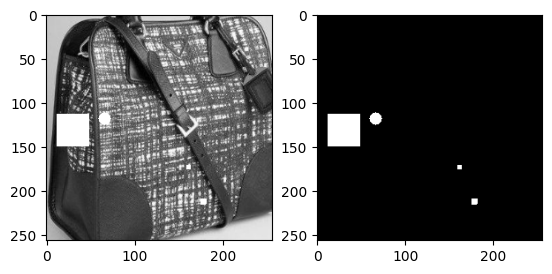

In [7]:
img, lab = train_loader.dataset[0][0].permute(1, 2, 0), train_loader.dataset[0][1].permute(1, 2, 0)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(lab, cmap="gray")
plt.show()

## Definició de la xarxa

Podem observar com es pot emprar l'orientació a objectes de **Python** per crear una xarxa de manera ordenada, és interessant analitzar aquest codi amb detall ja que en podem aprendre molt:

Aquí tenim 2 capes noves que ens ajudaràn a construïr la nova arquitectura:

- [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html): Aplica un operador de convolució transposat 2D sobre una imatge d'entrada composta per diversos plans d'entrada.    [Exemples gràfics](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md).
- [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html): És una tècnica utilitzada en l'entrenament de xarxes neuronals artificials per a estabilizar i accelerar el procés de convergència durant l'entrenament. Bàsicament, durant l'entrenament d'una red neuronal, els valors d'entrada de cada capa poden canviar a mesura que els paràmetres de les capes anteriors s'actualitzen. Això pot fer que l'entrenament sigui més lento o inestable. La normalització per lots resuelve això normalitzant les activacions de cada capa abans de passar a la següent capa.

In [8]:
from collections import OrderedDict


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features

        ## CODER
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        ## DECODER
        # TODO: Construeix el teu decoder
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        # Aplicarem una sigmoide a la sortida de la xarxa -> TODO: Recordar el que ha dit en biel a classe
        return torch.sigmoid(self.conv(dec1))

    # Ara ja podem començar a fer coses amb cara i ulls
    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

## Entrenament

Per fer tasques de segmentació, una de les funcions de pèrdua que podem emprar és el _Diceloss_ (intersecció vs unió):  El coeficient de _Dice_ s'utilitza habitualment en tasques de segmentació d'imatges com a mesura de la superposició entre les màscares de segmentació entre la predicció i el _ground truth_. El  _Diceloss_, és el complementari del coeficient de _Dice_, es pot utilitzar com a funció de pèrdua per entrenar models per a tasques de segmentació.

Dice Coefficient=$ = 2 \times \frac{|X \cap Y|}{|X| + |Y|}$



On:

- $X$ és la màscara de segmentació prevista.
- $Y$ és la màscara de segmentació de la veritat del sòl.
- $∣⋅∣$ denota la cardinalitat o el nombre d'elements d'un conjunt.

In [9]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 0.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

El bucle d'entrenament és diferent al que estau acostumats a veure en l'assignatura, s'assembla molt més als propis tutorials de _Pytorch_.

A més s'aprofita per introduir la visualització de resultats de forma dinàmica usant la llibreria [tqdm](https://github.com/tqdm/tqdm) i la llibreria _matplotlib_

In [10]:
torch.manual_seed(33)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

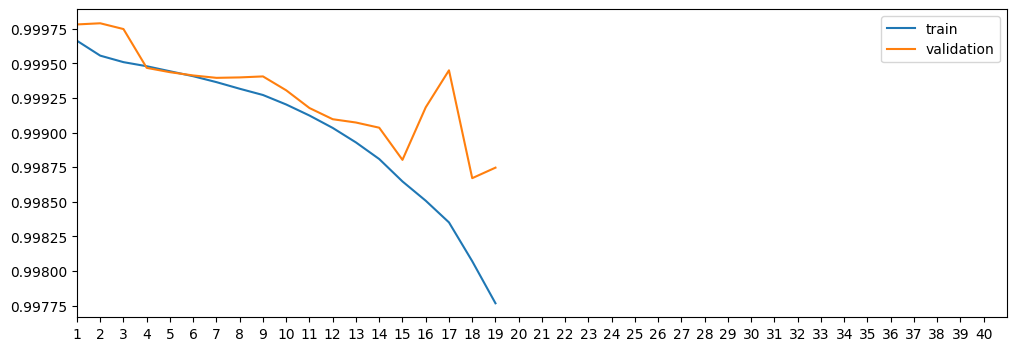

Epoch:19 Training Loss:0.9977668523788452 Validation Loss:0.9987468421459198


Training Epoch 20:  25%|██▌       | 2/8 [00:28<01:24, 14.13s/it]


KeyboardInterrupt: 

In [11]:
epochs = 40

model = UNet().to(device)

optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 

t_loss = np.zeros((epochs))
v_loss = np.zeros((epochs))

for epoch in range(1, epochs+1):
    
    train_loss = 0 
    val_loss = 0  
    
    model.train()                                                  
    for batch_num, (input_img, target) in tqdm(enumerate(train_loader, 1), total=len(train_loader), desc=f"Training Epoch {epoch}"):   
        input_img= input_img.to(device)
        target = target.to(device)
        
        output = model(input_img)
        loss = criterion(output, target)
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()     
        
        train_loss += loss.item()    
                                                       
    model.eval()   
    with torch.no_grad():                                          
        for input_img, target in tqdm(val_loader, total=len(val_loader), desc=f"Validation of Epoch {epoch}"):
            input_img = input_img.to(device)
            target = target.to(device)
            
            output = model(input_img)                                   
            loss = criterion(output, target)   
            val_loss += loss.item()  
    
    # RESULTATS
    train_loss /= len(train_loader)
    t_loss[epoch-1] = train_loss
    
    val_loss /= len(val_loader)   
    v_loss[epoch-1] = val_loss
    
    # VISUALITZACIO DINAMICA
    plt.figure(figsize=(12, 4))
    pl.plot(t_loss[:epoch], label="train")
    pl.plot(v_loss[:epoch], label="validation")
    pl.legend()
    pl.xlim(0, epochs)
    pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.close()

    print(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{val_loss}")

Guardam el model, d'aquesta manera no es necessari fer l'entrenament a classe:

In [ ]:
torch.save(model.state_dict(), "unet.pt")

## Avaluació

Carregam el model

In [ ]:
mmodel =  UNet().to(device)
mmodel.load_state_dict(torch.load("unet.pt"))
mmodel.eval();

**Feina a fer**

Visualitzar exemples de segmentació.

[agraïments Unet](https://github.com/mateuszbuda/brain-segmentation-pytorch)